In [1]:
import os
from joblib import Parallel, delayed
import time
import numpy as np
import pickle
import pylab as pl


In [2]:
time.sleep(80)

In [3]:
total_count = 48


In [4]:


def getTimesThputs(file):
    f = open(file, "r")
    data = f.readlines() 
    times = []
    thputs = []
    latencies = []
    for line in data:
        if not line.startswith('--') and 'current ops/sec; [UPDATE AverageLatency' in line:

#         print(line)
            times.append(line.split('sec:')[0].strip())
            thputs.append(line.split(';')[1].split('current')[0].strip())
            latencies.append(line.split('=')[1].split(']')[0].strip())
            
            print(line,latencies[-1],thputs[-1],times[-1])

    return np.array(times).astype(float), np.array(thputs).astype(float), np.array(latencies).astype(float)/1e6  






def getTimeThps(file, flag):
    
    f = open(file, "r")
    data = f.readlines() 

    times = []
    thputs = []
    for line in data:
        if 'throughput[ops/s]' in line:
            lineData = (line[13+line.find('max[ops/s])>'):-2])
            print(lineData)

            times.append(lineData.split('|')[0])
            thputs.append(lineData.split('|')[-2])
    if (flag): 
        times.append(float(times[-1])+abs(float(times[-1]) - float(times[-2]) ))
        thputs.append(0)
        
    return np.array(times).astype(float), np.array(thputs).astype(float) 

In [5]:
# os.system("aws --region ap-south-1 ec2 describe-instances  --filter Name=instance-type,Values=t2.small --query 'Reservations[*].Instances[*].[PrivateIpAddress]' --output text > all_internal_ips")

# os.system("aws --region ap-south-1 ec2 describe-instances --filter Name=instance-type,Values=t2.small --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text > all_external_ips")



# os.system("aws --region ap-south-1 ec2 describe-instances  --query 'Reservations[*].Instances[*].[PrivateIpAddress]' --output text > all_internal_ips")

# os.system("aws --region ap-south-1 ec2 describe-instances  --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text > all_external_ips")

In [6]:
with open('all_external_ips') as f:
    lines = f.read().splitlines()


lines = [x for x in lines if x!='None']
lines, len(lines)

(['65.0.80.238',
  '65.2.33.122',
  '13.127.177.175',
  '13.232.232.207',
  '13.235.132.64',
  '43.205.213.86',
  '3.110.106.118',
  '3.6.90.238',
  '3.108.194.231',
  '13.233.183.251',
  '15.206.145.201',
  '65.0.129.208',
  '3.108.221.101',
  '13.234.113.12',
  '43.205.231.174',
  '13.232.112.248',
  '13.232.244.136',
  '13.127.53.138',
  '43.205.203.220',
  '13.127.223.50',
  '13.234.59.208',
  '13.126.132.199',
  '13.127.175.161',
  '13.126.211.40',
  '52.66.147.236',
  '15.207.87.239',
  '43.204.25.50',
  '13.233.178.254',
  '13.233.34.168',
  '52.66.200.22',
  '43.205.194.79',
  '13.232.74.205',
  '43.205.231.202',
  '43.204.30.240',
  '3.110.182.243',
  '43.205.198.203',
  '65.2.170.185',
  '13.234.111.83',
  '15.206.79.126',
  '13.126.207.118',
  '13.232.177.182',
  '52.66.119.232',
  '3.110.170.129',
  '13.234.111.242',
  '13.127.189.177',
  '13.127.159.149',
  '65.0.89.212',
  '3.110.225.42',
  '65.2.170.217',
  '52.66.31.15',
  '13.235.244.45',
  '43.205.111.37',
  '43.205.2

In [7]:
for ip in lines:
    if ip!='None':
        current = (ip.split('.'))

        print('ssh -i "FinalKeys.pem" ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com')

ssh -i "FinalKeys.pem" ubuntu@ec2-65-0-80-238.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-65-2-33-122.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-13-127-177-175.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-13-232-232-207.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-13-235-132-64.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-43-205-213-86.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-3-110-106-118.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-3-6-90-238.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-3-108-194-231.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-13-233-183-251.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-15-206-145-201.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-65-0-129-208.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-3-108-221-

In [8]:
## Set number of clusters

nclusters = 0

for folder in os.listdir('.'):
    if 'config' in folder and folder!='config':
        nclusters = nclusters + 1
        
        
print(nclusters)




nreplicas = int(total_count/nclusters)
nodeIps = lines[:nclusters* nreplicas]

nclients = nclusters

# no_cluster_yet_nodes = lines[nclusters* nreplicas:-(nclusters)]
no_cluster_yet_nodes = lines[nclusters* nreplicas:-nclients]



# clientIps = lines[-(nclusters):]
clientIps = lines[-nclients:]



clientIps, no_cluster_yet_nodes

8


(['65.2.170.217',
  '52.66.31.15',
  '13.235.244.45',
  '43.205.111.37',
  '43.205.215.13',
  '52.66.207.248',
  '43.205.95.41',
  '43.205.112.213'],
 [])

In [9]:
## Functions

def setup(i):

    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'echo 3108 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'commands.sh'+' ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com:commands.sh'
        
        print(command)
        os.system(command)
        
def initialize(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'echo 3108 | sudo -S ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -t "sudo tc qdisc del dev eth0 root; sudo sh commands.sh; cd /home/ubuntu/BftSmart_Final/simul_latency/; sudo sh node_'+str(i)+'.sh"'
        
        
        os.system(command)
        
        
def git_clone(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -t " sudo git clone https://github.com/tmane002/BftSmart_Final.git"'
        
        
        os.system(command)
        
def git_pull(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -t "git config --global --add safe.directory /home/ubuntu/BftSmart_Final; cd BftSmart_Final; sudo git pull"'
        
        
        os.system(command)
        
def compile_job(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo ./gradlew installDist"'
        
        
        os.system(command)

        
        
def clean_job(i):
    ip = lines[i]
    
    rm_command = 'sudo rm config/currentView; '
    for iter_ in range(nclusters):
        rm_command = rm_command + 'sudo rm config'+str(iter_)+'/currentView; '
        
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "sudo rm nohup.out; cd BftSmart_Final; '+rm_command+'"'
        
        
        os.system(command)
        
        
def clean_all(i):
    ip = lines[i]
    
    rm_command = 'sudo rm -r BftSmart_Final; sudo rm nohup.out;sudo rm nohup_client.out;'

        
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "sudo rm nohup.out; '+rm_command+'"'
        
        
        os.system(command)
        
def run_server_node(i):
    ip = lines[i]
#     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
    if ip!='None' and( ip in nodeIps):
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
        os.system(command)
        
        
        
    if ip!='None' and( ip in no_cluster_yet_nodes):
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
        os.system(command)        
#         print(command)

def check_node(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -f -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "tail -n 1000 nohup.out"'
        
        
        os.system(command)
#         print(command)


def run_basic_client(i):
    cmd_arg = ''
    
    ip = lines[i]
    if ip!='None' and ip in clientIps:
#     if ip!='None' and ip in nodeIps[1:1+len(clientIps)]:
        
        current = (ip.split('.'))
        
#         cmd_arg = nodeIps[1:1+len(clientIps)].index(ip)
        
        for iter__ in range(len(clientIps)):
            if ip==clientIps[iter__]:
                cmd_arg = iter__
                
                
        
#         print(i, cmd_arg)
            
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com "cd BftSmart_Final; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup_client.out 2>&1 &"'

        
        os.system(command)


def kill_java(i):
    ip = lines[i]
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo killall java; sudo killall nohup"'
        
        
        os.system(command)
        
        
        
def kill_clients(i):
    ip = lines[i]
    if ip!='None' and ip in clientIps:
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo killall java; sudo killall nohup"'
        
        
        os.system(command)

def run_server_node_check(i):
    ip = lines[i]
#     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
    if ip!='None' and( ip in nodeIps):
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
        print(command)
        
        

# for i in range(len(lines)):
#     run_server_node_check(i)

def run_basic_client_check(i):
    cmd_arg = ''
    
    ip = lines[i]
    if ip!='None' and ip in clientIps:
        
        for iter__ in range(len(clientIps)):
            if ip==clientIps[iter__]:
                cmd_arg = iter__
                
                
        
#         print(i, cmd_arg)
            
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com "cd BftSmart_Final; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup.out 2>&1 &"'

        
        print(command)

In [10]:
# for i in range(len(lines)):
#     run_basic_client_check(i)
    

# def setup(i):

#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'commands.sh'+' ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:commands.sh'
        
        
#         os.system(command)
        
# def initialize(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -t "sudo sh commands.sh"'
        
        
#         os.system(command)
        
        
# def git_clone(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -t " sudo git clone https://tmane002@bitbucket.org/tmane002/BftSmart_Final.git"'
        
        
#         os.system(command)
        
# def git_pull(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -t "git config --global --add safe.directory /home/ubuntu/bftsmartt; cd bftsmartt; sudo git pull"'
        
        
#         os.system(command)
        
# def compile_job(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo ./gradlew installDist"'
        
        
#         os.system(command)

        
        
# def clean_job(i):
#     ip = lines[i]
    
#     rm_command = 'sudo rm config/currentView; '
#     for iter_ in range(nclusters):
#         rm_command = rm_command + 'sudo rm config'+str(iter_)+'/currentView; '
        
    
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "sudo rm nohup.out; cd bftsmartt; '+rm_command+'"'
        
        
#         os.system(command)
        
        
# def clean_all(i):
#     ip = lines[i]
    
#     rm_command = 'sudo rm -r bftsmartt; sudo rm nohup.out;sudo rm nohup_client.out;'

        
    
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "sudo rm nohup.out; '+rm_command+'"'
        
        
#         os.system(command)
        
# def run_server_node(i):
#     ip = lines[i]
# #     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
#     if ip!='None' and( ip in nodeIps):
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
#         os.system(command)
        
        
        
#     if ip!='None' and( ip in no_cluster_yet_nodes):
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
#         os.system(command)        
# #         print(command)

# def check_node(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -f -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "tail -n 1000 nohup.out"'
        
        
#         os.system(command)
# #         print(command)


# def run_basic_client(i):
#     cmd_arg = ''
    
#     ip = lines[i]
#     if ip!='None' and ip in clientIps:
# #     if ip!='None' and ip in nodeIps[1:1+len(clientIps)]:
        
#         current = (ip.split('.'))
        
# #         cmd_arg = nodeIps[1:1+len(clientIps)].index(ip)
        
#         for iter__ in range(len(clientIps)):
#             if ip==clientIps[iter__]:
#                 cmd_arg = iter__
                
                
        
# #         print(i, cmd_arg)
            
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com "cd bftsmartt; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup_client.out 2>&1 &"'

        
#         os.system(command)


# def kill_java(i):
#     ip = lines[i]
    
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo killall java; sudo killall nohup"'
        
        
#         os.system(command)
        
        
        
# def kill_clients(i):
#     ip = lines[i]
#     if ip!='None' and ip in clientIps:
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo killall java; sudo killall nohup"'
        
        
#         os.system(command)

# def run_server_node_check(i):
#     ip = lines[i]
# #     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
#     if ip!='None' and( ip in nodeIps):
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
#         print(command)
        
        

# # for i in range(len(lines)):
# #     run_server_node_check(i)

# def run_basic_client_check(i):
#     cmd_arg = ''
    
#     ip = lines[i]
#     if ip!='None' and ip in clientIps:
        
#         for iter__ in range(len(clientIps)):
#             if ip==clientIps[iter__]:
#                 cmd_arg = iter__
                
                
        
# #         print(i, cmd_arg)
            
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com "cd bftsmartt; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup.out 2>&1 &"'

        
#         print(command)

# # for i in range(len(lines)):
# #     run_basic_client_check(i)
    

In [11]:
## First Time Setup

lines, len(lines)

(['65.0.80.238',
  '65.2.33.122',
  '13.127.177.175',
  '13.232.232.207',
  '13.235.132.64',
  '43.205.213.86',
  '3.110.106.118',
  '3.6.90.238',
  '3.108.194.231',
  '13.233.183.251',
  '15.206.145.201',
  '65.0.129.208',
  '3.108.221.101',
  '13.234.113.12',
  '43.205.231.174',
  '13.232.112.248',
  '13.232.244.136',
  '13.127.53.138',
  '43.205.203.220',
  '13.127.223.50',
  '13.234.59.208',
  '13.126.132.199',
  '13.127.175.161',
  '13.126.211.40',
  '52.66.147.236',
  '15.207.87.239',
  '43.204.25.50',
  '13.233.178.254',
  '13.233.34.168',
  '52.66.200.22',
  '43.205.194.79',
  '13.232.74.205',
  '43.205.231.202',
  '43.204.30.240',
  '3.110.182.243',
  '43.205.198.203',
  '65.2.170.185',
  '13.234.111.83',
  '15.206.79.126',
  '13.126.207.118',
  '13.232.177.182',
  '52.66.119.232',
  '3.110.170.129',
  '13.234.111.242',
  '13.127.189.177',
  '13.127.159.149',
  '65.0.89.212',
  '3.110.225.42',
  '65.2.170.217',
  '52.66.31.15',
  '13.235.244.45',
  '43.205.111.37',
  '43.205.2

In [12]:
# for i in range(10):
#     setup(i)


results = Parallel(n_jobs=len(lines))(delayed(setup)(i) for i in range(len(lines)))
print(results)  

[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [13]:
results = Parallel(n_jobs=len(lines))(delayed(initialize)(i) for i in range(len(lines)))
print(results)  

[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-

Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]


fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' al

Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive

fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.


Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu

fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.


Fetched 227 kB in 1s (363 kB/s)
Reading package lists...Fetched 227 kB in 1s (339 kB/s)
Reading package lists...Fetched 227 kB in 1s (333 kB/s)
Reading package lists...Fetched 227 kB in 1s (348 kB/s)
Reading package lists...Fetched 227 kB in 1s (338 kB/s)
Reading package lists...Fetched 227 kB in 1s (326 kB/s)
Reading package lists...Fetched 227 kB in 1s (347 kB/s)
Reading package lists...Fetched 227 kB in 1s (346 kB/s)
Reading package lists...Fetched 227 kB in 1s (339 kB/s)
Reading package lists...Fetched 227 kB in 1s (345 kB/s)
Reading package lists...Fetched 227 kB in 1s (333 kB/s)
Reading package lists...Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Fetched 227 kB in 1s (334 kB/s)
Reading package lists...Fetched 227 kB in 1s (339 kB/s)
Reading package lists...Fetched 227 kB in 1s (344 kB/s)
Reading package lists...Fetched 227 kB in 1s (329 kB/s)
Reading package lists...Fetched 227 kB in 1s (328 kB/s)
Reading package lists...Fetched 227 kB in 1s (346 kB/s)
Reading

curl is already the newest version (7.81.0-1ubuntu1.13).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
curl is already the newest version (7.81.0-1ubuntu1.13).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.

Reading state information...

Reading state information...
curl is already the newest version (7.81.0-1ubuntu1.13).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
curl is already the newest version (7.81.0-1ubuntu1.13).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:         

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found



Building dependency tree...
Building dependency tree...
Reading state information...

Reading state information...

Reading state information...

Reading state information...

Reading state information...

Reading state information...
ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.

Reading state information...

Reading state information...Reading package lists...

Building dependency tree...
Reading state information...

Reading state information...
ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.

                                -+syyyyyyys:
                            `/yho:`       -yd.

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`            

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found


ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
Reading package lists...Reading package lists...Reading package lists...
ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
Building dependency tree...

Building dependency tree...Building dependency tree...Reading package lists...Reading package lists...Reading package lists...
Building dependency tree...

Reading package lists...
Reading state information...
Building dependency tree...Building dependency tree...ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.

ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.

Reading state information...
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.

Reading state information...
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: 'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
[sudo] password for tejas: [sudo] password for tejas: 'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
[sudo] password for tejas: [sudo] password for tejas: 'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
[sudo] password for tejas: [sudo] password for tejas: 'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
Pseudo-terminal will not be allocated because stdin is not a terminal.
'u

iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.

Reading state information...


[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: 'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
[sudo] password for tejas: Pseudo-terminal will not be allocated because stdin is not a terminal.


iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.


Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a 

Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]


Pseudo-terminal will not be allocated because stdin is not a terminal.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.


Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]


fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' al

Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:1 http://ap-

fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.


Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:1 http://ap-

fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.


Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Fetched 227 kB in 1s (344 kB/s)
Reading package lists...Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelea

fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.


Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Fetched 227 kB in 1s (327 kB/s)
Reading package lists...Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Fetched 227 kB in 1s (335 kB/s)
Reading package lists...Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Fetched 227 kB in 1s (340 kB/s)
Reading package lists...Fetched 227 kB in 1s (337 kB/s)
Reading package lists...Fetched 227 kB in 1s (342 kB/s)
Reading package lists...Fetched 227 kB in 1

Building dependency tree...Reading package lists...
Reading state information...

Building dependency tree...Reading package lists...
Reading state information...
Reading package lists...

Reading state information...curl is already the newest version (7.81.0-1ubuntu1.13).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.

Building dependency tree...curl is already the newest version (7.81.0-1ubuntu1.13).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.

Building dependency tree...
Reading state information...

Reading state information...build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
curl is already the newest version (7.81.0-1ubuntu1

job.sh: 11: sdk: not found


curl is already the newest version (7.81.0-1ubuntu1.13).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
Reading package lists...
Building dependency tree...curl is already the newest version (7.81.0-1ubuntu1.13).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
curl is already the newest version (7.81.0-1ubuntu1.13).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
curl is already the newest version (7.81.0-1ubuntu1.13).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.

Reading state information...

Reading state information...
curl is already the newest version (7.81.0-1ubuntu1.13).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found



                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       /MMM:       yh
          `+d+`           `:/oo/`       `-/osyh/ossssssdNMM`           .sh:         yMMN`      /m.
         -dh-           :ymNMMMMy  `-/shmNm-`:N/-.``   `.sN            /N-         `NMMy      .m/
  

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found



                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       /MMM:       yh
          `+d+`           `:/oo/`       `-/osyh/ossssssdNMM`           .sh:         yMMN`      /m.
         -dh-           :ymNMMMMy  `-/shmNm-`:N/-.``   `.sN            /N-         `NMMy      .m/
  

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found


Reading package lists...
Reading state information...
Building dependency tree...Building dependency tree...ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.

Reading package lists...Building dependency tree...
                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-           

Reading package lists...
Reading state information...

ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.

Reading state information...

Reading state information...
ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
Building dependency tree...ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
Reading package lists...
Reading state information...
Reading package lists...
Building dependency tree...

Reading state information...
Building dependency tree...
Reading state information...
Reading package lists...ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
Reading package lists...ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
Reading package lists...
Reading state information...
ant is 

job.sh: 11: sdk: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Building dependency tree...Building dependency tree...Building dependency tree...
Building dependency tree...ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.

Reading state information...
Reading package lists...
Reading package lists...Building dependency tree...Reading package lists...Reading package lists...ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.


Reading state information...

Building dependency tree...

Reading state information...
Building dependency tree...Building dependency tree...Reading package lists...ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.

Reading state information...


Building dependency tree...ant is already the newest version (1.10.12-1).
0 upgra

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Reading state information...
Reading package lists...
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
Building dependency tree...
Reading state information...
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.

Reading state information...

Reading state information...
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.

Reading state information...

Reading state information...
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.

Reading state information...



'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': 

iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.

Reading state information...
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.


'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [14]:
## GIT Clone/Pull



results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))


print(results)  

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': N

Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning 

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [15]:
## Compile Job

results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
print(results)  

Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURC

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated

Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent bui

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for de


> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava


Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

Note: Some input files use unchecked or unsafe operations.
Note: Recompi


> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava
> Task :jar

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :compileJava

> Task :compileJava

> Task :compileJava
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated A


> Task :compileJava
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :compileJava
> Task :processResources NO-SOURCE
> Task :classes


> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.

Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated


> Task :compileJava
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :jar


Note: Recompile with -Xlint:unchecked for details.


> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 20s
> Task :jar

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> T

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks:

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for de


> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

BUILD SUCCESSFUL i

Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [33]:
## CLEAN SERVERS

results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

print(results)  

rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config4/currentView': No such file or directory
rm: cannot remove 'config5/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config6/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config7/currentView'rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
: No such file or directory
r

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'config4/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config5/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config6/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config7/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cann

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config5/currentView': No such file or directory
rm: cannot remove 'config6/currentView': No such file or directory
cannot remove 'config1/currentView': No such file or directory
rm: rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: rm: cannot remove 'config7/currentView': No such file or directory
rm: cannot remove 'config7/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: rm: cannot remove 'config7/currentView': No such file or direc

In [34]:
## Setup Client and nodeIPS
len(nodeIps), len(clientIps)

(48, 8)

In [35]:
# ## RUN SERVERS

# results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# print(results)  

# ### CHECK NODE RESULT

# check_node(7)

# ## Run basic client

# # time.sleep(20)
# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# print(results)  

# check_node(0)

# time.sleep(60)

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))

In [58]:
## Main Job

# os.system('git add .; git commit -m "test";git push')

experiment = 'GeoRun_tot_'+str(total_count)+'_clusters_'+str(nclusters)

In [59]:
results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
# print(results) 




results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))


results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# print(results)  


print('XXXXXXXX Started Servers XXXXXXXXXXXX')

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': N

bash: line 1: cd: BftSmart_Final: No such file or directory
java: no process found
nohup: no process found
bash: line 1: cd: BftSmart_Final: No such file or directory
java: no process found
nohup: no process found
bash: line 1: cd: BftSmart_Final: No such file or directory
java: no process found
nohup: no process found
bash: line 1: cd: BftSmart_Final: No such file or directory
java: no process found
bash: line 1: cd: BftSmart_Final: No such file or directory
nohup: no process found
java: no process found
nohup: no process found
bash: line 1: cd: BftSmart_Final: No such file or directory
java: no process found
nohup: no process found
bash: line 1: cd: BftSmart_Final: No such file or directory
bash: line 1: cd: BftSmart_Final: No such file or directory
java: no process found
java: no process found
nohup: no process found
nohup: no process found
bash: line 1: cd: BftSmart_Final: No such file or directory
java: no process found
nohup: no process found
bash: line 1: cd: BftSmart_Final: No 

Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning in

Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated 

Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent bui

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated 


> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated AP


> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated A

> Task :installDist

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :compileJava
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava
> Task :jar
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :jar

> Task :compileJava
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes



Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist
> Task :installDist

> Task :installDist


> Task :processResources NO-SOURCE
> Task :classes

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

> Task :installDist

BUILD SUCCESSFUL

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :jar
BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :compileJava
BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
Starting a Gradle Daemon (subsequent builds will be faster)
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds 

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated 


> Task :compileJava
> Task :jar

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar
> Task :jar


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed


rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView'rm: cannot remove 'config/currentView': No such file or directory: No such file or directory

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config0/currentView'rm: cannot remove 'config0/currentView': No such file or directory: No such file or directoryrm: cannot remove 'config/currentView': No such file or directory


rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directoryrm: cannot remove 'config2/currentView': No such file or directory

rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'config3/c

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config4/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directoryrm: cannot remove 'config2/currentView': No such file or directory

rm: cannot remove 'config5/c

rm: cannot remove 'config7/currentView': No such file or directory

rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'config4/currentView': No such file or directory
rm: cannot remove 'config5/currentView': No such file or directory
rm: cannot remove 'config6/currentView': No such file or directory
rm: cannot remove 'config7/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config0/currentView'rm: cannot remove 'config0/currentView': No such file or directoryrm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory

rm: cannot remove 'config1/currentView': No such file or director

rm: cannot remove 'config4/currentView': No such file or directory
rm: cannot remove 'config5/currentView': No such file or directory
cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: 
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'config4/currentView': No such file or directory
rm: cannot remove 'config5/currentView': No such file or directory
rm: cannot remove 'config6/currentView': No such file or directorycannot remove 'config5/currentView': No such file or directory
rm: cannot remove 'config6/currentView': No such file or directory
rm: cannot remove 'config7/currentView': No such file or directory
rm: rm: cannot remove 'config7/currentView': No such file or direc

XXXXXXXX Started Servers XXXXXXXXXXXX


In [60]:
check_node(42)


In [61]:
time.sleep(240)

check_node(42)



print('XXXXXXXX Started Clients XXXXXXXXXXXX')

results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
time.sleep(350)

results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

config+cinfo.getClusterNumber(id) is: config7
-- Creating current view from configuration file
-- myPort, InetAddress.getByName(myAddress) and myAddress are: 11421, /172.31.35.199, 172.31.35.199
-- getConnection HERE 
-- Getting connection for ret: null, remoteId: 0
-- Getting connection for remoteId: 0
XXXXXXXX Started Clients XXXXXXXXXXXX
config+cinfo.getClusterNumber(id) is: config7
-- Creating current view from configuration file
-- myPort, InetAddress.getByName(myAddress) and myAddress are: 11421, /172.31.35.199, 172.31.35.199
-- getConnection HERE 
-- Getting connection for ret: null, remoteId: 0
-- Getting connection for remoteId: 0
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:0  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- After Adding connection, ret: bftsmart.communication.server.ServerConnection@7748410a
-- getConnection HERE 
-- Getting connection for ret: null, remoteId: 1
-- Getting connection for remoteId: 1
-- Reached here i

nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no proces

In [62]:
if not os.path.exists('../Experiments/'+experiment):
    os.mkdir('../Experiments/'+experiment)

os.system('cd ../Experiments/'+experiment+';rm *;cd ../; rm '+experiment+'.png')

for ip in nodeIps[:]:
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

        os.system(command)
        break
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_client.out'
# #         print(command)
#         os.system(command)

        
for ip in no_cluster_yet_nodes:
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

        os.system(command)
        

for ip in clientIps:    
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out'
        print(command)
        os.system(command)

rm: cannot remove 'GeoRun_tot_48_clusters_8.png': No such file or directory


scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-65-2-170-217.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/GeoRun_tot_48_clusters_8/nohup_client_48.out
scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-52-66-31-15.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/GeoRun_tot_48_clusters_8/nohup_client_49.out
scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-13-235-244-45.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/GeoRun_tot_48_clusters_8/nohup_client_50.out
scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-43-205-111-37.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/GeoRun_tot_48_clusters_8/nohup_client_51.out
scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-43-205-215-13.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_clie

 8 sec: 1 operations; 1 current ops/sec; [UPDATE AverageLatency(us)=2426641] 
 2426641 1 8
 9 sec: 100 operations; 98.8 current ops/sec; [UPDATE AverageLatency(us)=3975951.02] 
 3975951.02 98.8 9
 10 sec: 102 operations; 2 current ops/sec; [UPDATE AverageLatency(us)=1421071.5] 
 1421071.5 2 10
 11 sec: 201 operations; 98.8 current ops/sec; [UPDATE AverageLatency(us)=1942944.97] 
 1942944.97 98.8 11
 12 sec: 202 operations; 1 current ops/sec; [UPDATE AverageLatency(us)=1762645] 
 1762645 1 12
 13 sec: 301 operations; 98.9 current ops/sec; [UPDATE AverageLatency(us)=1961272.56] 
 1961272.56 98.9 13
 14 sec: 303 operations; 2 current ops/sec; [UPDATE AverageLatency(us)=1753076.5] 
 1753076.5 2 14
 15 sec: 402 operations; 98.9 current ops/sec; [UPDATE AverageLatency(us)=1705436.4] 
 1705436.4 98.9 15
 16 sec: 421 operations; 18.98 current ops/sec; [UPDATE AverageLatency(us)=1081040.26] 
 1081040.26 18.98 16
 17 sec: 521 operations; 99.9 current ops/sec; [UPDATE AverageLatency(us)=1797925.1

 13437943.56 16 302
 303 sec: 8445 operations; 6.99 current ops/sec; [UPDATE AverageLatency(us)=13474744.43] 
 13474744.43 6.99 303
 304 sec: 8451 operations; 6 current ops/sec; [UPDATE AverageLatency(us)=13488712.33] 
 13488712.33 6 304
 305 sec: 8458 operations; 6.99 current ops/sec; [UPDATE AverageLatency(us)=13473623.71] 
 13473623.71 6.99 305
 306 sec: 8465 operations; 7 current ops/sec; [UPDATE AverageLatency(us)=13484253.57] 
 13484253.57 7 306
 307 sec: 8471 operations; 6 current ops/sec; [UPDATE AverageLatency(us)=13465582] 
 13465582 6 307
 308 sec: 8478 operations; 7 current ops/sec; [UPDATE AverageLatency(us)=13476195.29] 
 13476195.29 7 308
 309 sec: 8485 operations; 6.99 current ops/sec; [UPDATE AverageLatency(us)=13473848.14] 
 13473848.14 6.99 309
 310 sec: 8492 operations; 7 current ops/sec; [UPDATE AverageLatency(us)=13450963.43] 
 13450963.43 7 310
 311 sec: 8498 operations; 6 current ops/sec; [UPDATE AverageLatency(us)=13460952.67] 
 13460952.67 6 311
 312 sec: 8505

 12392780.83 6 344
 345 sec: 5316 operations; 7 current ops/sec; [UPDATE AverageLatency(us)=12391310.86] 
 12391310.86 7 345
 346 sec: 5323 operations; 6.99 current ops/sec; [UPDATE AverageLatency(us)=12369036.71] 
 12369036.71 6.99 346
 347 sec: 5330 operations; 7 current ops/sec; [UPDATE AverageLatency(us)=12386940.71] 
 12386940.71 7 347
 348 sec: 5337 operations; 7 current ops/sec; [UPDATE AverageLatency(us)=12378066.14] 
 12378066.14 7 348
 349 sec: 5343 operations; 6 current ops/sec; [UPDATE AverageLatency(us)=12370593] 
 12370593 6 349
 350 sec: 5350 operations; 6.99 current ops/sec; [UPDATE AverageLatency(us)=12358592] 
 12358592 6.99 350
 351 sec: 5356 operations; 6 current ops/sec; [UPDATE AverageLatency(us)=12371220.33] 
 12371220.33 6 351
 352 sec: 5363 operations; 7 current ops/sec; [UPDATE AverageLatency(us)=12446625.86] 
 12446625.86 7 352
 353 sec: 5368 operations; 5 current ops/sec; [UPDATE AverageLatency(us)=12448305.8] 
 12448305.8 5 353
 354 sec: 5378 operations; 10

 5677546.5 5.99 102
 103 sec: 6740 operations; 7 current ops/sec; [UPDATE AverageLatency(us)=5716145.29] 
 5716145.29 7 103
 104 sec: 6747 operations; 6.99 current ops/sec; [UPDATE AverageLatency(us)=5752986] 
 5752986 6.99 104
 105 sec: 6771 operations; 24 current ops/sec; [UPDATE AverageLatency(us)=5911035.12] 
 5911035.12 24 105
 106 sec: 6821 operations; 49.95 current ops/sec; [UPDATE AverageLatency(us)=5959269.46] 
 5959269.46 49.95 106
 107 sec: 6827 operations; 5.99 current ops/sec; [UPDATE AverageLatency(us)=5944469.33] 
 5944469.33 5.99 107
 108 sec: 6834 operations; 6.99 current ops/sec; [UPDATE AverageLatency(us)=5942282] 
 5942282 6.99 108
 109 sec: 6840 operations; 6 current ops/sec; [UPDATE AverageLatency(us)=5960044.67] 
 5960044.67 6 109
 110 sec: 6847 operations; 7 current ops/sec; [UPDATE AverageLatency(us)=5939330.14] 
 5939330.14 7 110
 111 sec: 6872 operations; 24.98 current ops/sec; [UPDATE AverageLatency(us)=5863845.76] 
 5863845.76 24.98 111
 112 sec: 6921 opera

 37 sec: 1389 operations; 44.96 current ops/sec; [UPDATE AverageLatency(us)=5283139.89] 
 5283139.89 44.96 37
 38 sec: 1406 operations; 17 current ops/sec; [UPDATE AverageLatency(us)=5693645.94] 
 5693645.94 17 38
 39 sec: 1410 operations; 4 current ops/sec; [UPDATE AverageLatency(us)=5373650.25] 
 5373650.25 4 39
 40 sec: 1416 operations; 5.99 current ops/sec; [UPDATE AverageLatency(us)=5359104.17] 
 5359104.17 5.99 40
 41 sec: 1426 operations; 9.99 current ops/sec; [UPDATE AverageLatency(us)=5403794.1] 
 5403794.1 9.99 41
 42 sec: 1444 operations; 17.98 current ops/sec; [UPDATE AverageLatency(us)=5676280.33] 
 5676280.33 17.98 42
 43 sec: 1488 operations; 44 current ops/sec; [UPDATE AverageLatency(us)=6349208.36] 
 6349208.36 44 43
 44 sec: 1503 operations; 15 current ops/sec; [UPDATE AverageLatency(us)=6396203.27] 
 6396203.27 15 44
 45 sec: 1509 operations; 5.99 current ops/sec; [UPDATE AverageLatency(us)=6373920] 
 6373920 5.99 45
 46 sec: 1515 operations; 5.99 current ops/sec; [U

 3208381.18 17 43
 44 sec: 1510 operations; 5 current ops/sec; [UPDATE AverageLatency(us)=3369869.2] 
 3369869.2 5 44
 45 sec: 1515 operations; 5 current ops/sec; [UPDATE AverageLatency(us)=3428176] 
 3428176 5 45
 46 sec: 1604 operations; 88.91 current ops/sec; [UPDATE AverageLatency(us)=3597831.52] 
 3597831.52 88.91 46
 47 sec: 1609 operations; 5 current ops/sec; [UPDATE AverageLatency(us)=3161155.4] 
 3161155.4 5 47
 48 sec: 1614 operations; 5 current ops/sec; [UPDATE AverageLatency(us)=3157557.4] 
 3157557.4 5 48
 49 sec: 1690 operations; 75.92 current ops/sec; [UPDATE AverageLatency(us)=3290301.83] 
 3290301.83 75.92 49
 50 sec: 1708 operations; 18 current ops/sec; [UPDATE AverageLatency(us)=3463179.61] 
 3463179.61 18 50
 51 sec: 1714 operations; 5.99 current ops/sec; [UPDATE AverageLatency(us)=3136445.33] 
 3136445.33 5.99 51
 52 sec: 1789 operations; 75 current ops/sec; [UPDATE AverageLatency(us)=3061993.24] 
 3061993.24 75 52
 53 sec: 1794 operations; 5 current ops/sec; [UPDA

 7 sec: 1 operations; 1 current ops/sec; [UPDATE AverageLatency(us)=630691] 
 630691 1 7
 9 sec: 101 operations; 99.9 current ops/sec; [UPDATE AverageLatency(us)=2124736.52] 
 2124736.52 99.9 9
 10 sec: 103 operations; 1.99 current ops/sec; [UPDATE AverageLatency(us)=1116976.5] 
 1116976.5 1.99 10
 11 sec: 201 operations; 97.9 current ops/sec; [UPDATE AverageLatency(us)=2069727.98] 
 2069727.98 97.9 11
 12 sec: 301 operations; 100 current ops/sec; [UPDATE AverageLatency(us)=1480083.02] 
 1480083.02 100 12
 13 sec: 303 operations; 2 current ops/sec; [UPDATE AverageLatency(us)=1263903] 
 1263903 2 13
 14 sec: 403 operations; 100 current ops/sec; [UPDATE AverageLatency(us)=1786031.4] 
 1786031.4 100 14
 15 sec: 440 operations; 37 current ops/sec; [UPDATE AverageLatency(us)=1124315.38] 
 1124315.38 37 15
 16 sec: 510 operations; 69.93 current ops/sec; [UPDATE AverageLatency(us)=1555633.93] 
 1555633.93 69.93 16
 17 sec: 602 operations; 92 current ops/sec; [UPDATE AverageLatency(us)=1585535

 8 sec: 1 operations; 1 current ops/sec; [UPDATE AverageLatency(us)=2337919] 
 2337919 1 8
 9 sec: 100 operations; 98.8 current ops/sec; [UPDATE AverageLatency(us)=3850899.8] 
 3850899.8 98.8 9
 10 sec: 102 operations; 2 current ops/sec; [UPDATE AverageLatency(us)=1315230.5] 
 1315230.5 2 10
 11 sec: 201 operations; 98.8 current ops/sec; [UPDATE AverageLatency(us)=2062617] 
 2062617 98.8 11
 12 sec: 202 operations; 1 current ops/sec; [UPDATE AverageLatency(us)=1930786] 
 1930786 1 12
 13 sec: 302 operations; 99.9 current ops/sec; [UPDATE AverageLatency(us)=2097019.41] 
 2097019.41 99.9 13
 14 sec: 303 operations; 1 current ops/sec; [UPDATE AverageLatency(us)=937788] 
 937788 1 14
 15 sec: 404 operations; 100.9 current ops/sec; [UPDATE AverageLatency(us)=1188744.57] 
 1188744.57 100.9 15
 16 sec: 504 operations; 100 current ops/sec; [UPDATE AverageLatency(us)=969749.22] 
 969749.22 100 16
 17 sec: 605 operations; 100.9 current ops/sec; [UPDATE AverageLatency(us)=1237439.87] 
 1237439.87

 37 sec: 1210 operations; 3 current ops/sec; [UPDATE AverageLatency(us)=3279875.67] 
 3279875.67 3 37
 38 sec: 1298 operations; 87.91 current ops/sec; [UPDATE AverageLatency(us)=3710297.34] 
 3710297.34 87.91 38
 39 sec: 1303 operations; 5 current ops/sec; [UPDATE AverageLatency(us)=3788190.8] 
 3788190.8 5 39
 40 sec: 1307 operations; 4 current ops/sec; [UPDATE AverageLatency(us)=3965627] 
 3965627 4 40
 41 sec: 1350 operations; 43 current ops/sec; [UPDATE AverageLatency(us)=3615014.79] 
 3615014.79 43 41
 42 sec: 1397 operations; 46.95 current ops/sec; [UPDATE AverageLatency(us)=3920883.26] 
 3920883.26 46.95 42
 43 sec: 1401 operations; 4 current ops/sec; [UPDATE AverageLatency(us)=4217666] 
 4217666 4 43
 44 sec: 1407 operations; 6 current ops/sec; [UPDATE AverageLatency(us)=4118918.67] 
 4118918.67 6 44
 45 sec: 1413 operations; 5.99 current ops/sec; [UPDATE AverageLatency(us)=4074282.17] 
 4074282.17 5.99 45
 46 sec: 1454 operations; 40.96 current ops/sec; [UPDATE AverageLatency(

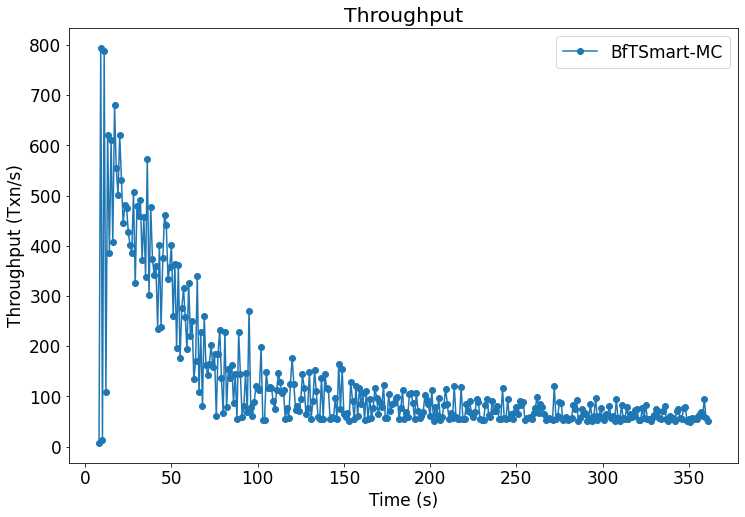

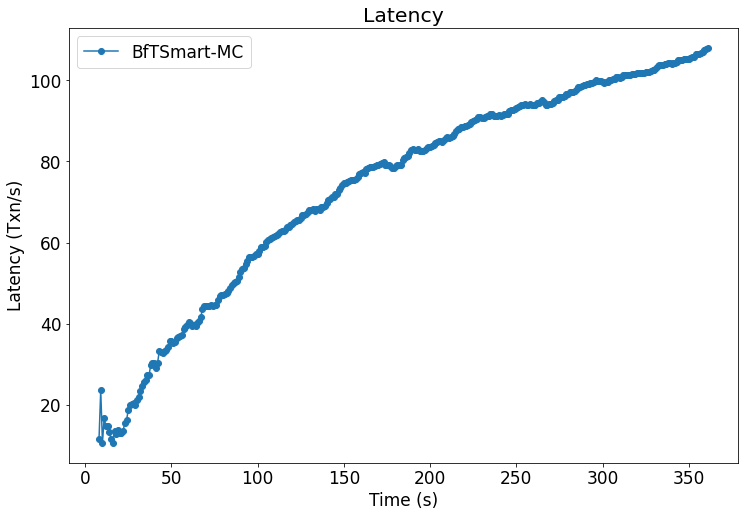

In [63]:
times_thputsDict = {}
times_latsDict = {}

for ip in clientIps[:1]:    
    i = lines.index(ip)
    
    times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
    for i in range(len(times)):
        times_thputsDict[times[i]] = thputs[i]
        times_latsDict[times[i]] = lats[i]
        

for ip in clientIps[1:]:    
    i = lines.index(ip)
    
    times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
    for i in range(len(times)):
        
        if times[i] in times_thputsDict.keys():
            times_thputsDict[times[i]] += thputs[i]
            
        if times[i] in times_latsDict.keys():
            times_latsDict[times[i]] += lats[i]
    

PIK = '../Experiments/'+experiment+"/pickle.dat"

data = [times_thputsDict, times_latsDict]

with open(PIK, "wb") as f:
    pickle.dump(data, f)


data2 = []
with open(PIK, "rb") as f:
    data2 =  pickle.load(f)


dict1 = data2[0]
dict2 = data2[1]



times1 = np.array(list(dict1.keys()))
thputs = np.array(list(dict1.values()))

times2 = np.array(list(dict2.keys()))
lats = np.array(list(dict2.values()))

times1

import pylab as pl

pl.figure(figsize = (12,8))
pl.rcParams.update({'font.size': 17})
pl.plot(times1[:], thputs[:], '-o', label='BfTSmart-MC')


pl.title(r'Throughput')


pl.xlabel('Time (s)')
pl.ylabel('Throughput (Txn/s)')
pl.legend()
pl.savefig('../Experiments/'+experiment+'/out1.png', dpi = 150)
pl.show()




pl.figure(figsize = (12,8))
pl.rcParams.update({'font.size': 17})
pl.plot(times1[:], lats[:], '-o', label='BfTSmart-MC')


pl.title(r'Latency')


pl.xlabel('Time (s)')
pl.ylabel('Latency (Txn/s)')
pl.legend()
pl.savefig('../Experiments/'+experiment+'/out2.png', dpi = 150)
pl.show()

In [64]:
lats, np.average(lats[-85:-5])

(array([ 11.49592   ,  23.52403594,  10.607223  ,  16.82081898,
         14.64444652,  14.68692064,  13.20576651,  11.60337046,
         10.56406545,  13.4973858 ,  12.87704309,  13.68686917,
         12.95177846,  13.07707678,  13.6369928 ,  15.61349864,
         16.29096615,  18.77183511,  19.82019278,  20.19809071,
         20.43436254,  19.97043461,  21.12557265,  21.82016968,
         23.43384378,  24.63548498,  25.51421777,  26.0798464 ,
         27.3575355 ,  27.29890865,  29.77688016,  30.17972878,
         30.40553242,  29.11828794,  30.4124815 ,  33.36796931,
         32.97377343,  32.84217053,  33.17950507,  33.49345876,
         34.1322147 ,  35.78948586,  35.67091354,  35.30817569,
         35.51213693,  36.39682483,  36.77018156,  36.89864461,
         37.1234171 ,  38.68978589,  39.24833977,  39.64125255,
         40.34392942,  40.04595966,  39.4858257 ,  39.7384721 ,
         39.48634674,  40.06959968,  40.65773357,  41.61371586,
         43.55378389,  44.2839196 ,  44.